In [1]:
import torch
import torch.nn as nn
from itertools import combinations_with_replacement

def quantize(x, bits, dev = 'cpu'):
    maxq = torch.tensor(2**bits - 1)

    tmp = torch.zeros(x.shape[0], device=dev)
    xmin = torch.minimum(x.min(1)[0], tmp) #Rowwise minimums
    xmax = torch.maximum(x.max(1)[0], tmp) #Rowwise minimums

    tmp = (xmin == 0) & (xmax == 0)
    xmin[tmp] = -1
    xmax[tmp] = +1

    if maxq < 0:
        scale = xmax
        zero = xmin
    else:
        scale = (xmax - xmin) / maxq
        zero = torch.round(-xmin / scale)

    if maxq < 0:
        return (x > scale / 2).float() * scale + (x < zero / 2).float() * zero
    
    q = torch.clamp(torch.round(x / scale) + zero, 0, maxq)
    return scale * (q - zero)

def find_combinations(n):
    target_sum = 4 * n
    result = []

    # Generate possible values for the integers (1 to target_sum)
    possible_values = range(1, target_sum + 1)

    # Use combinations_with_replacement to generate combinations with non-increasing order
    for combo in combinations_with_replacement(possible_values, 4):
        if sum(combo) == target_sum:
            # Reverse to ensure the order is non-increasing
            sorted_combo = tuple(sorted(combo, reverse=True))
            result.append(sorted_combo)

    return result

Greedy column reordering and quantization

In [21]:
#torch.manual_seed(0)
winners = 0
for i in range(1000):
    size = 100

    #Split quantization without reordering
    A = torch.randn(size,size)
    B = torch.randn(size,size)
    B2 = torch.clone(B)
    out = torch.matmul(A,B)

    B4 = quantize(B,4)
    B8 = quantize(B,8)
    
    B[:,size//2:size] = B4[:,size//2:size]
    B[:,:size//2] = B8[:,:size//2] 

    test_out = torch.matmul(A,B)

    #Find largest columns by means
    largest_col = torch.argsort(-torch.mean(A,axis=0))

    #Reorder columns according to their mean
    A = A[:,largest_col] 
    B = B2[largest_col,:]

    B4 = quantize(B,4)
    B8 = quantize(B,8)
    
    B[:,size//2:size] = B4[:,size//2:size]
    B[:,:size//2] = B8[:,:size//2] 

    quantOut = torch.matmul(A,B)

    error = torch.norm(out - test_out) 
    error2 = torch.norm(out - quantOut)  
    winners = winners+1 if error2>error else winners
    
print(winners)

511


Now test with different blocks

In [22]:
#Split matrix in 4 blocks
import numpy as np

base_quant = 4
combinations = find_combinations(base_quant)
expansion_factors = [1.05,1.25,1.5,1.75,2,2.5,3,5,7.5,10]
best_combinations = []
best_scores = []
for expansion_factor in expansion_factors:
    best_comb = None
    best_score = 0
    for comb in combinations:
        curr_error = []
        for i in range(50):
            A = torch.rand(100,100) 
            top_left = torch.rand(50,50)*expansion_factor**3 #Multiplication according to the expansion factor
            top_right = torch.rand(50,50)*expansion_factor**2
            bottom_left = torch.rand(50,50)*expansion_factor**1
            bottom_right = torch.rand(50,50)

            # Full FP32 matrix
            B1 = torch.zeros(100, 100) 
            B1[:50, :50] = top_left          
            B1[:50, 50:] = top_right         
            B1[50:, :50] = bottom_left       
            B1[50:, 50:] = bottom_right      
            out1 = torch.matmul(A,B1)

            top_left = quantize(top_left,comb[0]) 
            top_right = quantize(top_right,comb[1])
            bottom_left = quantize(bottom_left,comb[2]) 
            bottom_right = quantize(bottom_right,comb[3]) 

            # Matrix with variable quantization
            B2 = torch.zeros(100, 100) 
            B2[:50, :50] = top_left          
            B2[:50, 50:] = top_right         
            B2[50:, :50] = bottom_left       
            B2[50:, 50:] = bottom_right     
            out2 = torch.matmul(A,B2)
            error1 = torch.norm(out1 - out2) 

            # Matrix with fixed quantization
            B3 = torch.zeros(100, 100) 
            B3 = quantize(B1,base_quant)
            out3 = torch.matmul(A,B3)
            error2 = torch.norm(out1 - out3)  
            
            #Append difference in errors (The larger, the better)
            curr_error.append(error2-error1)
            
        mean = np.mean(curr_error) 
        
        if mean>best_score:
            best_score = mean
            best_comb = comb
    
    best_combinations.append(best_comb)
    best_scores.append(best_score)

KeyboardInterrupt: 

[(4, 4, 4, 4), (4, 4, 4, 4), (5, 4, 4, 3), (5, 5, 3, 3), (6, 5, 3, 2), (6, 5, 3, 2), (6, 4, 4, 2), (7, 4, 3, 2), (8, 4, 3, 1), (8, 4, 3, 1)]


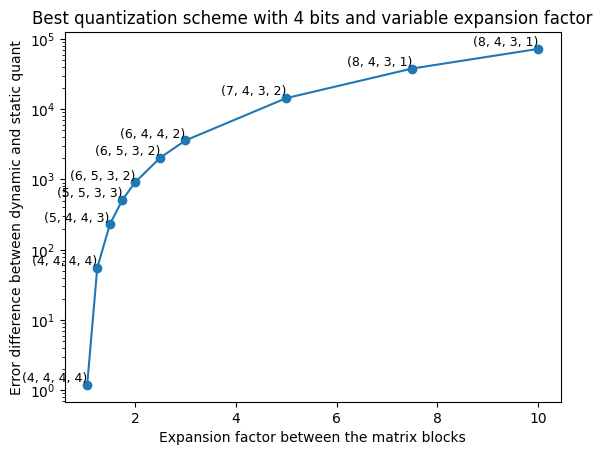

In [81]:
import matplotlib.pyplot as plt

print(best_combinations)
plt.plot(expansion_factors,best_scores,marker='o', linestyle='-')
plt.title('Best quantization scheme with 4 bits and variable expansion factor')
plt.xlabel('Expansion factor between the matrix blocks')
plt.ylabel('Error difference between dynamic and static quant')
plt.yscale('log')
for i, (x, y) in enumerate(zip(expansion_factors, best_scores)):
    plt.text(x, y, best_combinations[i], fontsize=9, ha='right', va='bottom')
plt.show()

Now test with real matrix from the model 

In [18]:
import torch

test = torch.randn(2,2)
args = torch.argsort(-test.view(-1).abs())
print(args)
print(test)

# Get the shape of the original tensor
rows, cols = test.shape
num_elements = rows * cols

# Create an identity matrix of size equal to the number of elements
identity = torch.eye(num_elements)

# Rearrange the identity matrix rows based on `args`
permutation_matrix = identity[args]

print("Permutation Matrix:")
print(permutation_matrix)

tensor([1, 0, 3, 2])
tensor([[ 0.3327, -0.8487],
        [-0.1529, -0.2385]])
Permutation Matrix:
tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.]])


In [111]:
torch.manual_seed(1)
A = torch.randn(10,10)  
B = torch.tensor([[-1.5256, 1.7502, 2.6540, -2.6095],
        [-1.1002, 1.6092, 2.9798, -2.6091],
        [-1.7121,  1.3037, 2.7773, -2.2515],
        [-1.2223,  1.6871,  2.2284,  -2.4676]])

print(A.std(axis=0))
print(B.std(axis=0))
      
A_q = quantize(A,8)
B_q = quantize(B,4)

print(torch.norm(A-A_q))
print(torch.norm(B-B_q))


tensor([1.3320, 0.5150, 1.4172, 0.9302, 1.1485, 0.9724, 0.9881, 0.9667, 0.6240,
        0.5439])
tensor([0.2794, 0.1978, 0.3175, 0.1690])
tensor(2.9258)
tensor(0.5287)


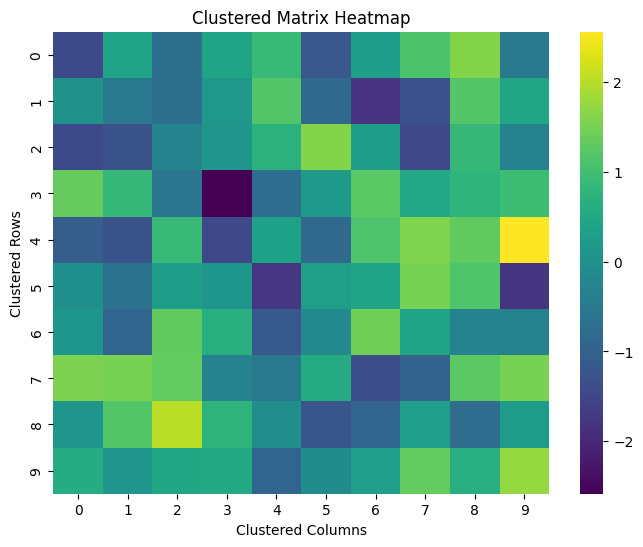

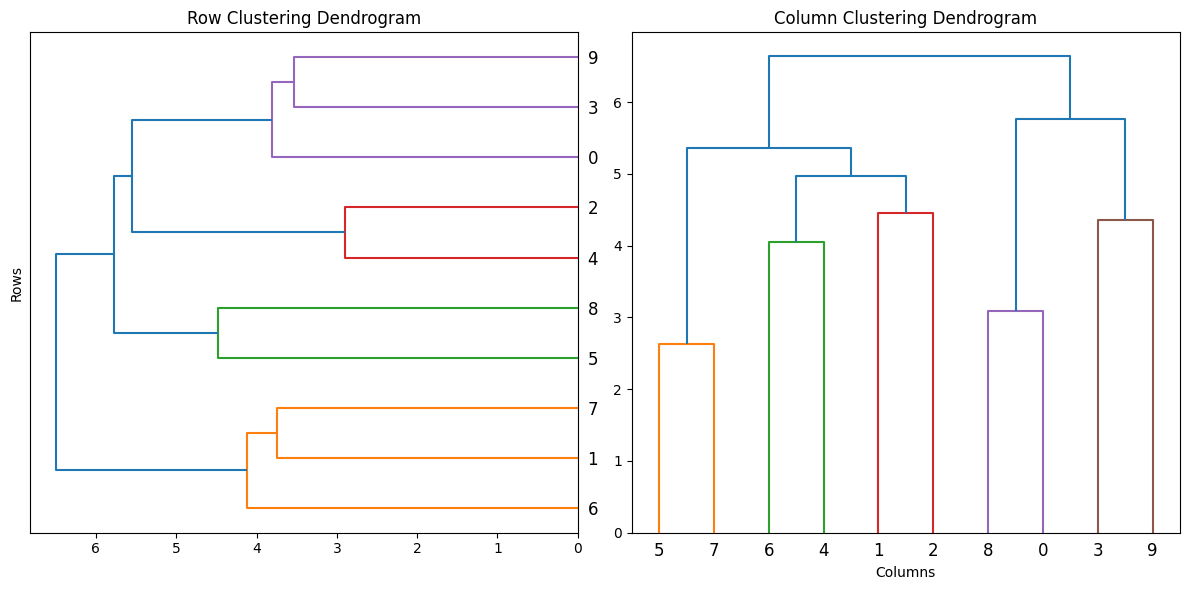

In [107]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list

# Step 1: Define a 2D torch tensor
matrix = torch.randn(10, 10)  # Example tensor
matrix_np = matrix.numpy()  # Convert to NumPy for clustering

# Step 2: Perform hierarchical clustering
# Cluster rows
row_linkage = linkage(matrix_np, method='ward')
row_order = leaves_list(row_linkage)

# Cluster columns
col_linkage = linkage(matrix_np.T, method='ward')
col_order = leaves_list(col_linkage)

# Reorder the matrix based on clustering
clustered_matrix = matrix_np[row_order, :][:, col_order]

# Step 3: Plot the clustered matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(clustered_matrix, cmap='viridis', cbar=True)
plt.title("Clustered Matrix Heatmap")
plt.xlabel("Clustered Columns")
plt.ylabel("Clustered Rows")
plt.show()

# (Optional) Dendrograms for rows and columns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Row dendrogram
dendrogram(row_linkage, ax=ax[0], orientation='left', labels=row_order)
ax[0].set_title("Row Clustering Dendrogram")
ax[0].set_ylabel("Rows")

# Column dendrogram
dendrogram(col_linkage, ax=ax[1], orientation='top', labels=col_order)
ax[1].set_title("Column Clustering Dendrogram")
ax[1].set_xlabel("Columns")

plt.tight_layout()
plt.show()


In [10]:
import torch
import numpy as np
torch.manual_seed(1)

# Step 1: Define a 2D tensor (matrix)
matrix = torch.randn(10, 10) # Example matrix with 10 rows and 5 columns

# Step 2: Apply Fourier Transform column-wise
fft_matrix = torch.fft.fft(matrix, dim=0)  # Apply FFT along columns
print(fft_matrix)
# Step 3: Quantize the Fourier Coefficients
# Example: Round the real and imaginary parts of each column

quantized_fft_matrix = torch.clamp(torch.round(fft_matrix.real),-8,7) + 1j * torch.clamp(torch.round(fft_matrix.real),-8,7)

print(quantized_fft_matrix)

reconstructed_matrix = torch.fft.ifft(quantized_fft_matrix, dim=0).real  # Use .real to get the real part

print(torch.norm(matrix-reconstructed_matrix))

tensor([[-2.1571e+00+0.0000j, -9.3874e-01+0.0000j, -5.8462e+00+0.0000j,
          4.0406e-01+0.0000j,  3.7951e+00+0.0000j, -3.9147e+00+0.0000j,
         -4.0969e+00+0.0000j, -3.9721e+00+0.0000j, -1.1816e+00+0.0000j,
         -2.3604e+00+0.0000j],
        [-5.6256e+00+0.9540j,  7.8475e-01-0.0360j, -1.2445e+00-5.4185j,
         -4.2520e-03-1.9583j, -3.1352e+00-3.2315j, -1.3061e+00-1.5945j,
         -3.4541e+00-0.3001j, -1.8304e+00+2.5203j,  1.3419e-01+0.1390j,
          2.8674e-01-0.6657j],
        [-3.0552e+00-5.5463j, -1.3597e+00+1.9883j, -1.5733e+00+2.7539j,
         -2.1151e+00-1.4883j,  6.5714e-02+1.4878j,  2.6627e+00-1.8770j,
          1.9925e+00+3.7942j, -7.4165e-01+3.6477j, -2.3556e+00-2.1816j,
          1.1390e+00+0.2796j],
        [ 3.0551e-01-0.7942j, -1.0542e+00-0.0526j,  2.3982e-01-3.2926j,
         -4.0741e+00-2.7672j, -2.8488e+00-3.3774j, -3.5531e+00-1.1004j,
          1.7870e+00-1.8847j, -2.9460e+00-0.0745j, -8.6693e-01-1.4700j,
          4.8658e-01-1.7257j],
        [ 4.

In [13]:
def remove_largest_x_percent(tensor, x_percent):
    flat_tensor = tensor.view(-1)
    abs_tensor = flat_tensor.abs()
    num_elements = flat_tensor.numel()
    num_to_remove = int(num_elements * (x_percent / 100))
    if num_to_remove == 0:
        return tensor  
    threshold = torch.topk(abs_tensor, num_to_remove, largest=True).values.min() #Get the values at the treshold
    mask = abs_tensor <= threshold  # Mask for keeping values
    large_vals = flat_tensor.clone()
    flat_tensor[~mask] = 0  # Set the largest values to 0
    large_vals[mask] = 0
    return flat_tensor.view_as(tensor), large_vals.view_as(tensor)

Matrix quantization plus sparse matrix

In [28]:
import torch
import numpy

percents = numpy.logspace(-2,2,50)
gains = torch.zeros(100,50)
for j,percent in enumerate(percents):
    for i in range(100):
        # Step 1: Define a 2D tensor (matrix)
        matrix = torch.randn(100, 100) 
        A = torch.rand(100,100)
        base_res = A@matrix

        quant = quantize(matrix,4)
        quant_res = A@quant
        quant_norm = torch.norm(base_res-quant_res).item() 
        
        C,D = remove_largest_x_percent(matrix,percent)
        C = quantize(C,4)
        sparse_res = A@C+A@D
        base_norm = torch.norm(sparse_res-base_res).item()
        
        gain = base_norm/quant_norm*100
        gains[i,j] = gain

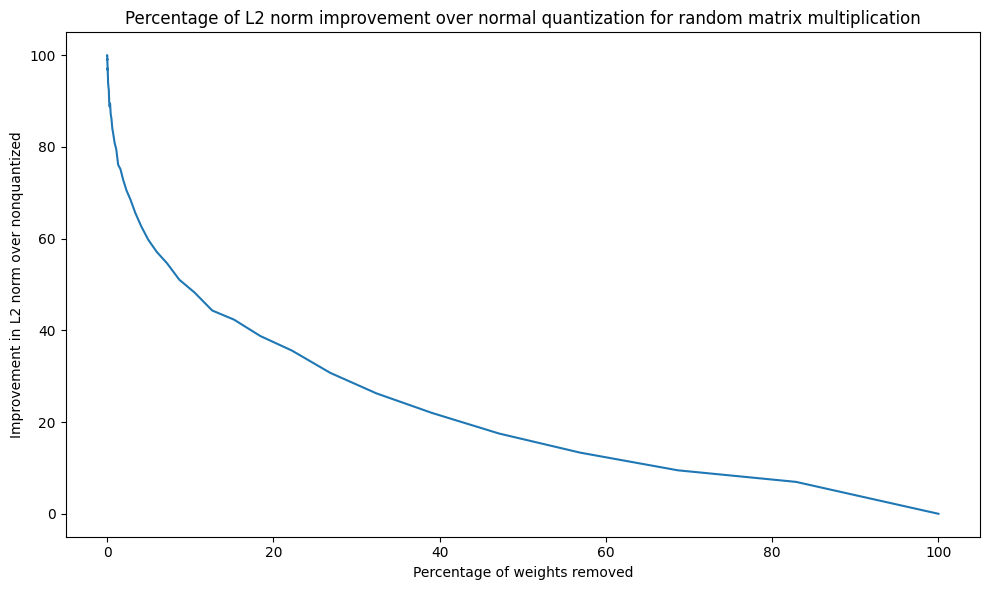

In [30]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

plt.plot(percents,gains.mean(axis=0))

plt.ylabel('Improvement in L2 norm over nonquantized')
plt.title('Percentage of L2 norm improvement over normal quantization for random matrix multiplication')
plt.xlabel('Percentage of weights removed')
plt.tight_layout()
plt.show()